In [45]:
import requests
from helpers import flatten_dict, petition_slug_to_id
import pandas as pd

In [72]:
def petition_milestones_request(petition_id, cursor):
    """Obtain the request to obtain the milestones for a petition."""

    # string below copied from Developer Tools
    petition_signatures_graphql_post_request = \
    \
    "{\"operationName\":\"PetitionDetailsPagePetitionStats\",\"variables\":{\"petitionId\":\"9878990\",\"count\":12,\"types\":[\"MILESTONE\",\"STARTER\",\"DM_RESPONSE\",\"STAFF\",\"FEATURED_NEWS\"],\"cursor\":\"YXJyYXljb25uZWN0aW9uOjIx\"},\"query\":\"query PetitionDetailsPagePetitionStats($petitionId: ID!, $count: Int!, $types: [PetitionUpdateType!]!, $cursor: ID) {\\n  petition: petitionById(id: $petitionId) {\\n    id\\n    slug\\n    user {\\n      id\\n      displayName\\n      photo {\\n        id\\n        userSmall {\\n          url\\n          processing\\n        }\\n      }\\n    }\\n    organization {\\n      id\\n      name\\n      photo {\\n        id\\n        userSmall {\\n          url\\n          processing\\n        }\\n      }\\n    }\\n    updatesConnection: petitionUpdatesConnection(\\n      types: $types\\n      first: $count\\n      after: $cursor\\n    ) {\\n      nodes {\\n        __typename\\n        id\\n        createdAt\\n        ... on MilestonePetitionUpdate {\\n          signatureCount\\n        }\\n        ... on StarterPetitionUpdate {\\n          title\\n          description\\n          ...MediaFields\\n        }\\n        ... on StaffPetitionUpdate {\\n          title\\n          description\\n          ...MediaFields\\n        }\\n        ... on FeaturedNewsPetitionUpdate {\\n          title\\n          ...MediaFields\\n        }\\n        ... on DmResponsePetitionUpdate {\\n          title\\n          description\\n          ...MediaFields\\n          dmResponse {\\n            id\\n            decisionMaker {\\n              id\\n              displayName\\n              photo {\\n                id\\n                userSmall {\\n                  url\\n                  processing\\n                }\\n              }\\n            }\\n          }\\n        }\\n      }\\n      pageInfo {\\n        endCursor\\n        hasNextPage\\n      }\\n    }\\n  }\\n}\\n\\nfragment MediaFields on PetitionUpdateWithMedia {\\n  photo {\\n    id\\n    petitionMedium {\\n      url\\n      processing\\n    }\\n  }\\n  video {\\n    photo {\\n      id\\n      petitionMedium {\\n        url\\n        processing\\n      }\\n    }\\n  }\\n  embeddedMedia {\\n    providerName\\n    photoUrl\\n    description\\n  }\\n}\\n\"}"
    
    petition_signatures_graphql_post_request_template = \
        petition_signatures_graphql_post_request.\
        replace('9878990', str(petition_id)).\
        replace('YXJyYXljb25uZWN0aW9uOjIx', cursor)
    
    return petition_signatures_graphql_post_request_template


def get_milestones_dataframe(petition_id: str):
    """Obtain a dataframe with the signatures."""

    # see above how we got it
    url = 'https://www.change.org/api-proxy/graphql'

    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:85.0) Gecko/20100101 Firefox/85.0',
        'Accept': 'application/json',
        'Accept-Language': 'en-US,en;q=0.5',
        'Referer': 'https://www.change.org/',
        'content-type': 'application/json',
        'X-Requested-With': 'http-link',
        'Origin': 'https://www.change.org',

        'Sec-GPC': '1',
        'Pragma': 'no-cache',
        'Cache-Control': 'no-cache',
        'TE': 'Trailers'
    }
    
    results = []

    # the POST request
    hasNextPage = True
    endCursor = ""
    while hasNextPage:
        data_str = petition_milestones_request(petition_id=petition_id,
                                               cursor=endCursor).strip()
        
        # issuing the request
        x = requests.post(url, data=data_str, headers=headers)
        d = x.json()
        
        print(f"Response: {x.status_code} {x.reason}")
        
        hasNextPage = d['data']['petition']['updatesConnection']['pageInfo']['hasNextPage']
        endCursor = d['data']['petition']['updatesConnection']['pageInfo']['endCursor']
        
        print(hasNextPage, endCursor)
        
        results.append(d)
        
    try:
        df = pd.concat([pd.DataFrame(z['data']['petition']['updatesConnection']['nodes']) for z in results])
        df = df.reset_index()
        del df['index']
    except:
        df = None
        
    return {'raw': results, 'df': df}

In [54]:
petition_id = petition_slug_to_id('pomóżcie-nam-powstrzymać-deportację-julii-i-jej-rodziny')

In [55]:
petition_id

9878990

In [73]:
data = get_milestones_dataframe(petition_id)

Response: 200 OK
True YXJyYXljb25uZWN0aW9uOjEx
Response: 200 OK
True YXJyYXljb25uZWN0aW9uOjIz
Response: 200 OK
False YXJyYXljb25uZWN0aW9uOjMx


In [69]:
data['raw'][3]['data']['petition']['updatesConnection']['nodes']

IndexError: list index out of range

In [75]:
df = data['df']

In [87]:
df.createdAt = pd.to_datetime(df.createdAt)

<AxesSubplot:xlabel='createdAt'>

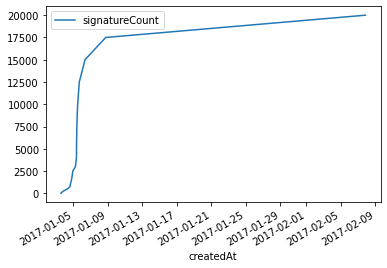

In [88]:
df[df['__typename'] == 'MilestonePetitionUpdate'].plot('createdAt', 'signatureCount')

In [82]:
df.columns

Index(['__typename', 'id', 'createdAt', 'title', 'description', 'photo',
       'video', 'embeddedMedia', 'signatureCount'],
      dtype='object')

In [89]:
!pip install filecache